# Diamond Price Prediction Model

## Problem Statement

          

> 1. How to build and choose a model that correctly estimate or predict the price of diamond in the marketplace based on its features?
> 2. How to determine what are the factors connected to diamond price and what should be done by investors/buyers and diamond manufacturing company to maximize their profit/obtain their desired goods?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Importing data

In [2]:
raw_data=pd.read_csv('diamonds.csv', index_col=0)

# Identifying Data

## 1. Identify available variables
### A. View available classes

In [3]:
pd.set_option('display.max_columns', None)
raw_data.head()

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,culet_condition,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,unknown,62.7,59.0,2.85,2.87,1.79,M,M,unknown,None,unknown,unknown,unknown,unknown,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,unknown,None,unknown,unknown,unknown,unknown,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,unknown,None,unknown,unknown,unknown,unknown,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,unknown,None,unknown,unknown,unknown,unknown,200


### B. Identify numerical from categorical variables

In [4]:
raw_data.dtypes

cut                             object
color                           object
clarity                         object
carat_weight                   float64
cut_quality                     object
lab                             object
symmetry                        object
polish                          object
eye_clean                       object
culet_size                      object
culet_condition                 object
depth_percent                  float64
table_percent                  float64
meas_length                    float64
meas_width                     float64
meas_depth                     float64
girdle_min                      object
girdle_max                      object
fluor_color                     object
fluor_intensity                 object
fancy_color_dominant_color      object
fancy_color_secondary_color     object
fancy_color_overtone            object
fancy_color_intensity           object
total_sales_price                int64
dtype: object

In [5]:
num_var=["carat_weight", "depth_percent", "table_percent", "meas_length", "meas_width", "meas_depth", "total_sales_price"]
cat_var=["cut", "color", "clarity", "cut_quality", "lab", "symmetry", "polish", "eye_clean", "culet_size", "culet_condition", "girdle_min", "girdle_max",
         "fluor_color", "fluor_intensity", "fancy_color_dominant_color", "fancy_color_secondary_color", "fancy_color_overtone", "fancy_color_intensity"]

### C. Separate numerical and categorical variables

In [6]:
num_data = raw_data[num_var].copy()
cat_data = raw_data[cat_var].copy()

### D. Calculate ratio of outliers

In [7]:
def find_outliers(numeric_data_column):
    q1, q3 = np.percentile(numeric_data_column, [25, 75])
    iqr = q3 - q1
    cutoff_low = q1 - (1.5 * iqr)
    cutoff_high = q3 + (1.5 * iqr)
    outliers = [x for x in numeric_data_column if x < cutoff_low or x > cutoff_high]
    return outliers

outlier_percentages = []

for col in num_data.columns:
    col_outliers = find_outliers(num_data[col])
    col_outliers_percent = len(col_outliers) / len(num_data[col]) * 100
    outlier_percentages.append(col_outliers_percent)

print("Outlier percentage:")
for i, col in enumerate(num_data.columns):
    print(f"{col}: {outlier_percentages[i]:.2f}%")

Outlier percentage:
carat_weight: 4.30%
depth_percent: 15.84%
table_percent: 12.16%
meas_length: 4.50%
meas_width: 5.21%
meas_depth: 4.15%
total_sales_price: 12.44%


> It is observed that all the numerical variables are highly skewed and have many outliers. 

## 2. Cleaning data

In [8]:
clean_data=raw_data.copy()

### A. Dropping irrelevant columns and rows
#### i. Replace "unknown" with NaN
> Done to make removing easier if necessary

In [9]:
clean_data=clean_data.replace('(unknown)', regex=True, value=np.nan)

#### ii. Count the ratio of NaN in each
> Print if NaN exists, i.e. ratio > 0

In [10]:
temp=clean_data.isnull().sum()/len(clean_data)
print(temp[temp>0]*100)

color                           4.170175
cut_quality                    27.585877
eye_clean                      71.421874
culet_size                     39.025412
culet_condition                93.027405
girdle_min                     37.974902
girdle_max                     38.367705
fluor_color                    92.842155
fluor_intensity                 0.058260
fancy_color_dominant_color     95.828914
fancy_color_secondary_color    99.516620
fancy_color_overtone           99.072384
fancy_color_intensity          95.829825
dtype: float64


#### iii. Dropping columns
> We can drop columns with more than 60% NaN.

In [11]:
for col in clean_data:
    na_percent = clean_data[col].isna().sum()/len(clean_data)
    if na_percent > 0.6:
        clean_data.drop(col, axis=1, inplace=True)

In [12]:
cat_var=["cut", "color", "clarity", "cut_quality", "lab", "symmetry", "polish", "culet_size", "girdle_min", "girdle_max"]

> Given that each variables have different distribution of classes, we chose to impute the value using proportional imputation to preserve the existing data ratio

In [13]:
def prop_impute(x):
    proportions = clean_data[x].value_counts(normalize=True)
    clean_data[x].fillna(pd.Series(np.random.choice(proportions.index,
                                                    size=len(clean_data.index),
                                                    p=proportions.values)),
                                                    inplace=True)
for var in cat_var:
    prop_impute(var)

In [14]:
clean_data.isna().sum(axis=0)

cut                    0
color                  1
clarity                0
carat_weight           0
cut_quality            1
lab                    0
symmetry               0
polish                 0
culet_size             1
depth_percent          0
table_percent          0
meas_length            0
meas_width             0
meas_depth             0
girdle_min             1
girdle_max             1
fluor_intensity      128
total_sales_price      0
dtype: int64

> Update the new list of categorical variables.

In [15]:
cat_var=["cut", "color", "clarity", "cut_quality", "lab", "symmetry", "polish", "culet_size", "girdle_min", "girdle_max", "fluor_intensity"]

clean_data=clean_data.reset_index()

# Exploratory Data Analysis (EDA)

## 1. Removing outliers
> In order to have a better general view of the data, we should remove outliers from EDA data before performing EDA, allowing us to work on a representative sample and identify general patterns.

> The removal is based on IQR definition

In [16]:
EDA_data = pd.DataFrame(clean_data)

EDA_num = EDA_data[num_var].copy()

Q1 = EDA_num.quantile(0.25)
Q3 = EDA_num.quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
outlier_mask = ((EDA_num<(Q1-threshold*IQR))|(EDA_num>(Q3+threshold*IQR))).any(axis=1)

EDA_data = clean_data[~outlier_mask]

EDA_data = EDA_data.drop(columns=['level_0', 'index'], errors='ignore')

EDA_data = EDA_data.reset_index()

EDA_data.head()

print(f"Number of rows in numeric_data: {len(EDA_num)}")
print(f"Number of rows after removing outliers: {len(EDA_data)}")

Number of rows in numeric_data: 219703
Number of rows after removing outliers: 157874


## 2. Univariate Analysis

### A. Distribution of variables
> Plotting the values for numerical variables

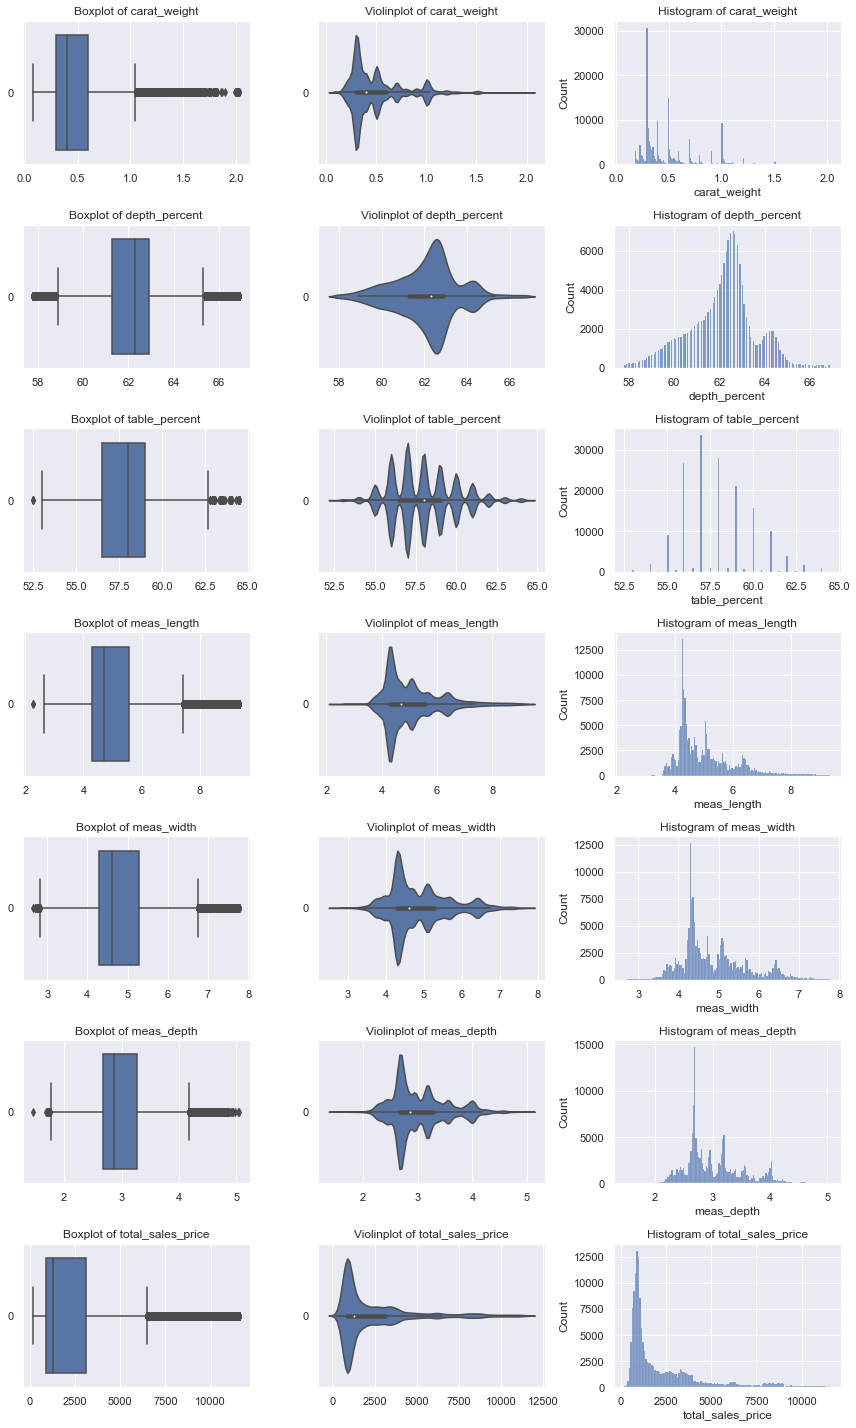

In [17]:
EDA_num=EDA_data[num_var].copy()

f, axes = plt.subplots(7, 3, figsize=(12, 20))
count = 0
for var in EDA_num:
    sb.boxplot(data=EDA_num[var], orient="h", ax=axes[count, 0])
    sb.violinplot(data=EDA_num[var], orient="h", ax=axes[count, 1])
    sb.histplot(data=EDA_num[var], ax=axes[count, 2])
    axes[count, 0].set_title(f"Boxplot of {var}")
    axes[count, 1].set_title(f"Violinplot of {var}")
    axes[count, 2].set_title(f"Histogram of {var}")
    EDA_num[var].describe()
    count += 1
plt.tight_layout()
plt.show()

We can see that the majority of diamonds have a price lower than $3000.

Most of the variables have outliers to the right, indicating how there are rare larger-sized dimesions but not much smaller-sized ones. This may be due to the lack of demand of smaller-sized diamonds.

### B. Skewness of variables

In [18]:
print(EDA_num.skew())

carat_weight         1.487993
depth_percent       -0.170814
table_percent        0.498286
meas_length          1.359834
meas_width           0.869911
meas_depth           0.839636
total_sales_price    1.862718
dtype: float64


Some of the categorical variables such as carat_weight, meas_length, and total_sales_price are strongly skewed.

## 3. Analyze Numerical Data

### A. Heatmap of Numeric Data

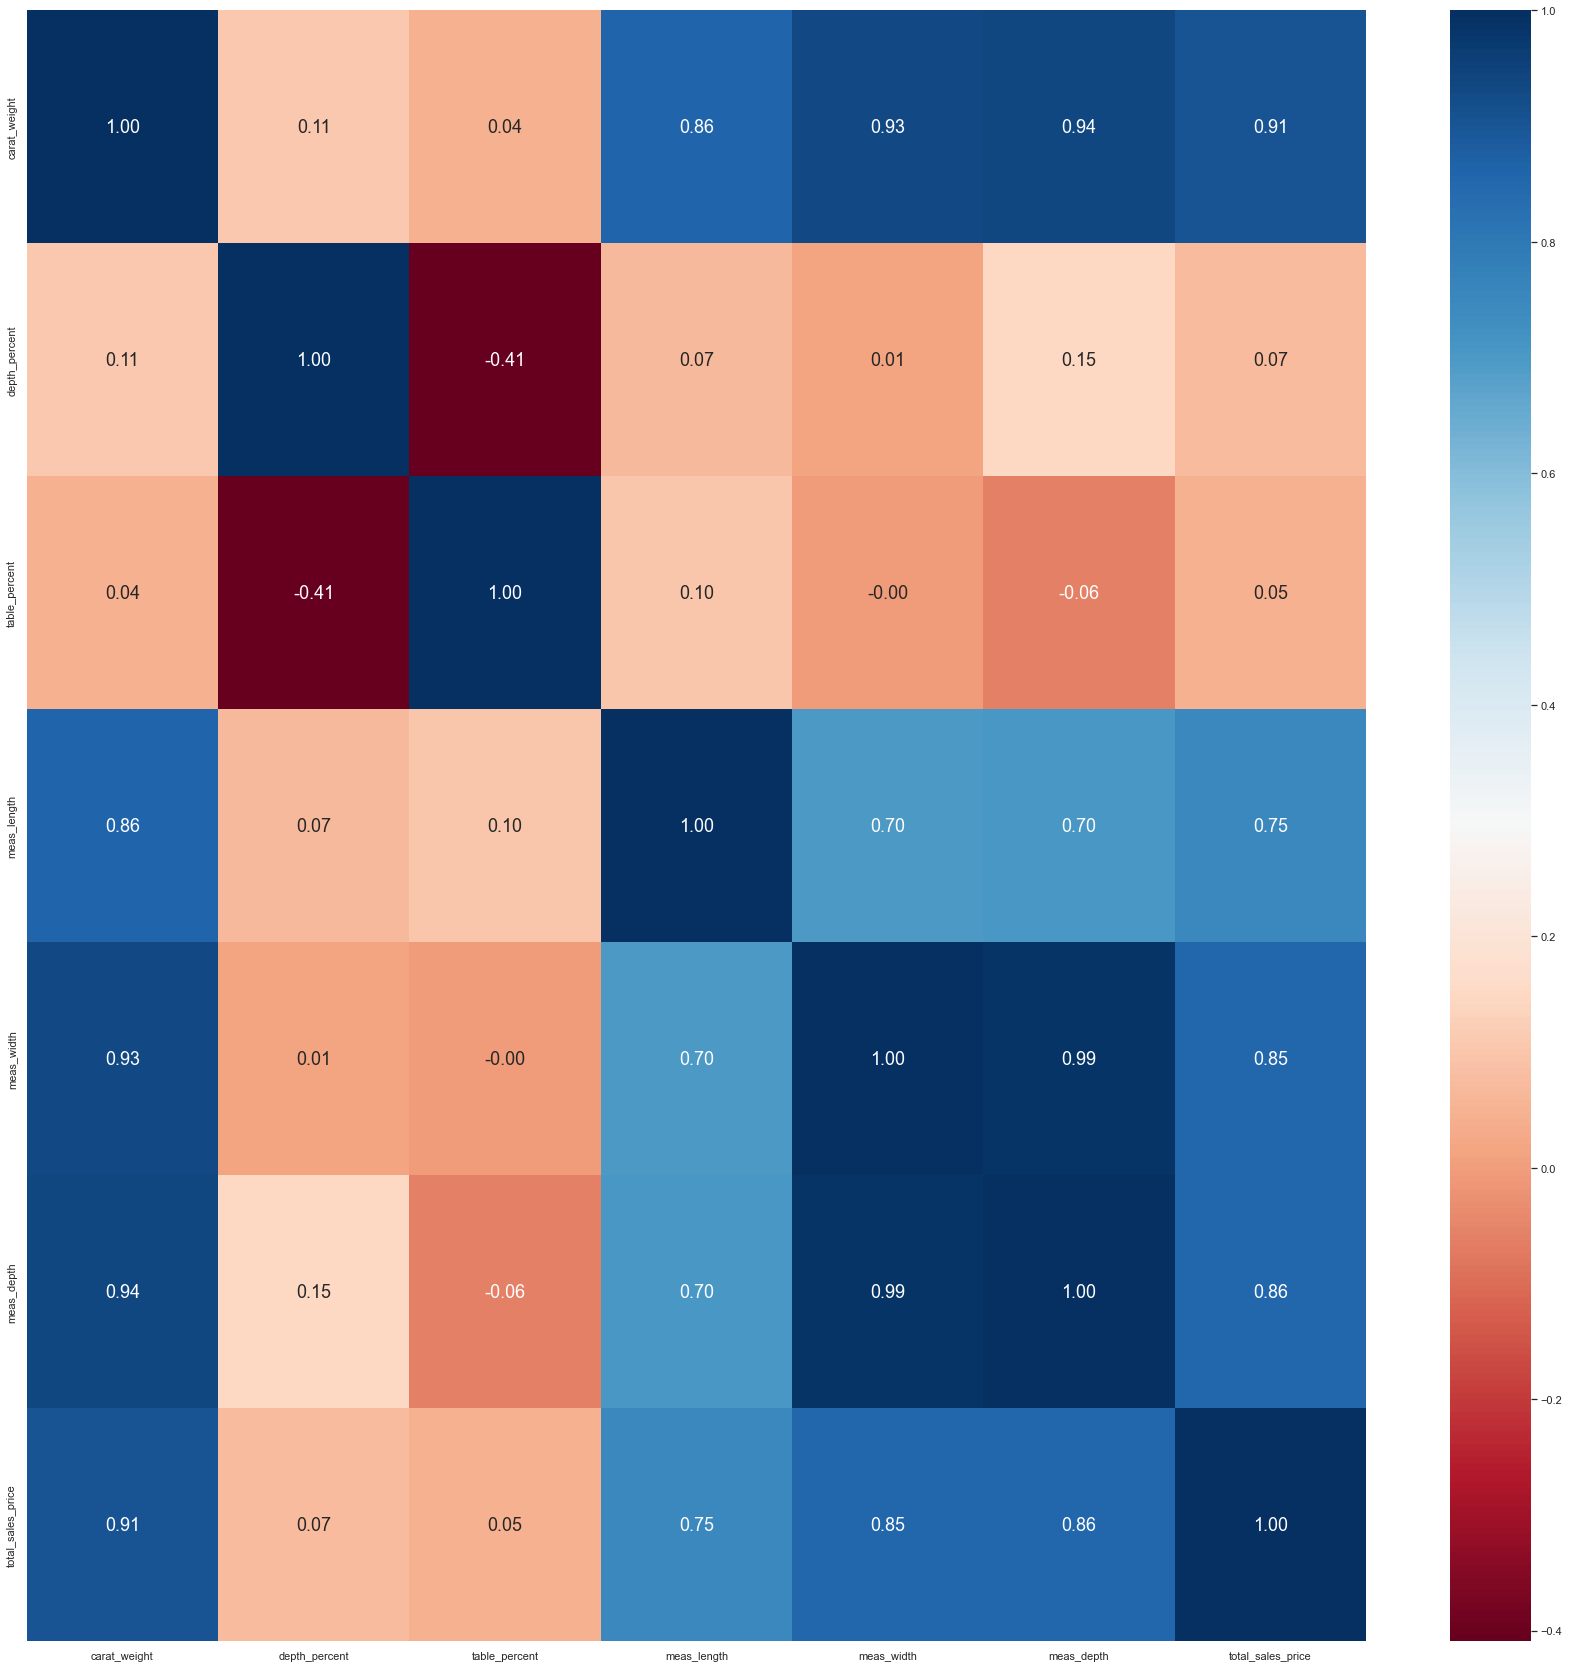

In [19]:
f = plt.figure(figsize=(30, 30))
sb.heatmap(EDA_num.corr(), annot=True, fmt=".2f", annot_kws={"size": 18}, cmap="RdBu")
plt.show()

### B. Pairplot

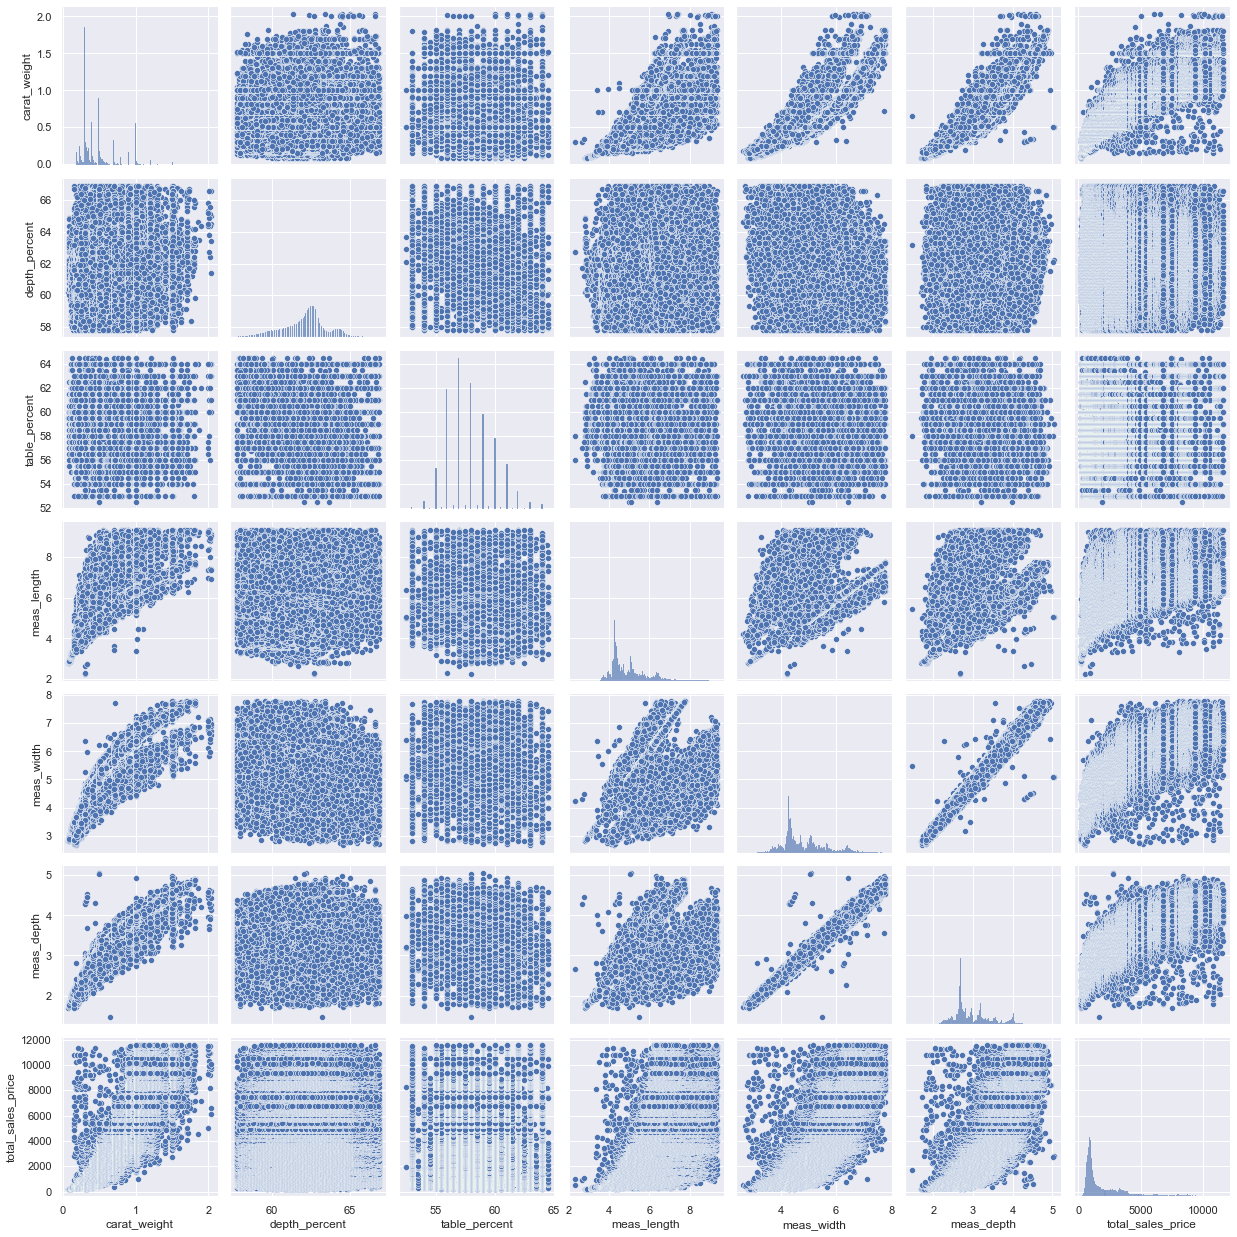

In [20]:
sb.pairplot(data = EDA_num)

> Observations:
> - carat_weight, meas_width, meas_length and meas_depth strongly related to total_sales_price &rarr; a larger dimension costs more
> - depth_percent and table_percent low correlation with total_sales_price

## 4. Analyze Categorical Data
### A. Distribution
Distribution of classes within each categorical data

In [21]:
EDA_cat=EDA_data[cat_var]

def plot_catplot(x):
    print(EDA_cat[x].value_counts())
    sb.catplot(y = x, data = EDA_cat, kind = "count")

Round               138648
Oval                  8248
Pear                  5550
Heart                 2155
Marquise              1556
Emerald               1067
Cushion Modified       349
Radiant                159
Asscher                103
Cushion                 36
Princess                 3
Name: cut, dtype: int64


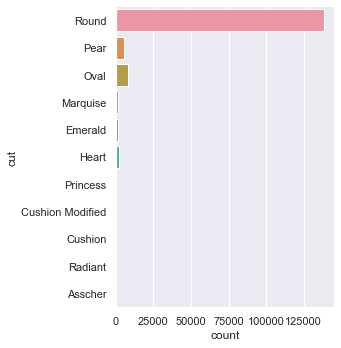

In [22]:
plot_catplot('cut') 

> Round is the most common cut form

E    25627
F    24146
D    23707
G    21160
H    18844
I    16393
J    12340
K     9001
L     4393
M     2263
Name: color, dtype: int64


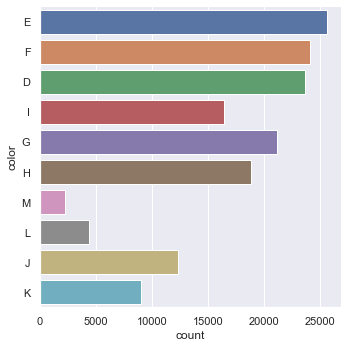

In [23]:
plot_catplot('color') 

> 'E' is the most common color.
>
> It is also worth noting that the distribution of color across its classes is significantly more even than cut.

N     155767
VS      1431
S        498
M        132
L         38
SL         5
VL         3
Name: culet_size, dtype: int64


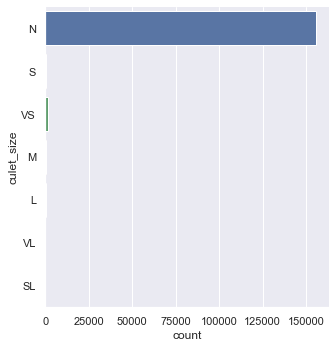

In [24]:
plot_catplot('culet_size') 

> The large majority has 'N' culet_size which is the ideal size according to the documentation Kaggle

Excellent    124053
Very Good     33806
Good             13
Fair              2
Name: cut_quality, dtype: int64


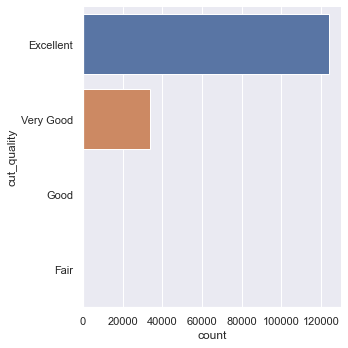

In [25]:
plot_catplot('cut_quality') 

Excellent    106462
Very Good     50729
Good            640
Fair             43
Name: symmetry, dtype: int64


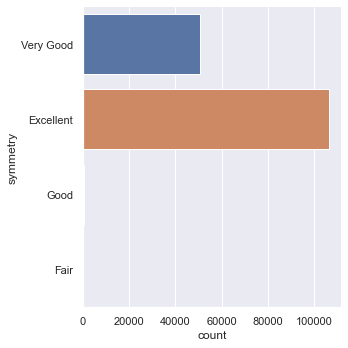

In [26]:
plot_catplot('symmetry') 

Excellent    130967
Very Good     26674
Good            230
Fair              3
Name: polish, dtype: int64


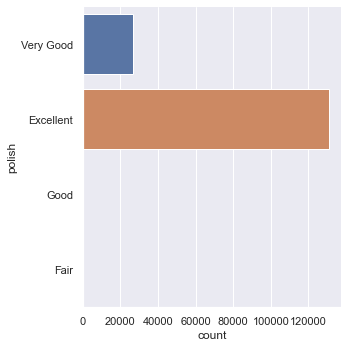

In [27]:
plot_catplot('polish') 

> The large majority of diamonds has "Excellent" polish, symmetry, and cut_quality

SI1     27820
VS2     27353
VS1     25647
SI2     22019
VVS2    21162
VVS1    20959
IF       7270
I1       4947
I2        646
I3         51
Name: clarity, dtype: int64


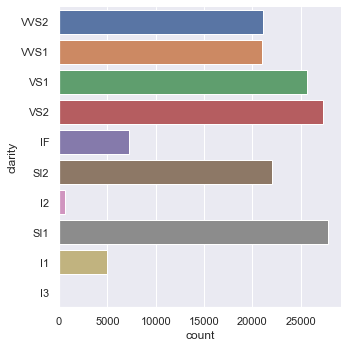

In [28]:
plot_catplot('clarity') 

> clarity is also more evenly disributed, similar to color

STK    91464
TK     27764
M      22532
VTK     9282
XTK     4987
TN      1678
VTN      119
XTN       29
STN       19
Name: girdle_max, dtype: int64


(None,)

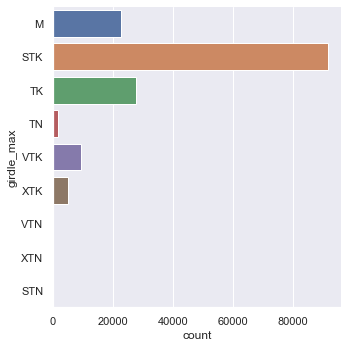

In [29]:
plot_catplot('girdle_max'), 

> Similarly, the large majority has 'STK' girdle_max where the girdle is slightly thick.

M      94969
STK    29684
TN     19853
TK      7795
VTK     2646
VTN     1735
XTK      968
XTN      203
STN       21
Name: girdle_min, dtype: int64


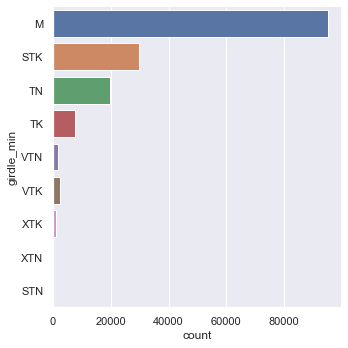

In [30]:
plot_catplot('girdle_min')

> The large majority has 'STK' girdle_min where the girdle is slightly thick.

None           102004
Faint           28078
Medium          15256
Strong           9931
Very Slight      1692
Very Strong       902
Slight              1
Name: fluor_intensity, dtype: int64


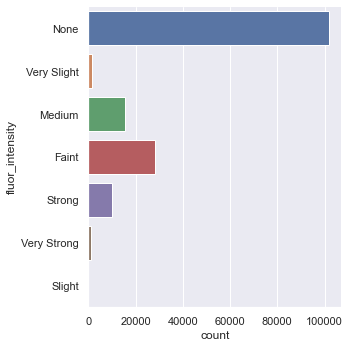

In [31]:
plot_catplot('fluor_intensity')

> Flour intensity refers to the effect of long wave UV light and most of the diamonds are not affected by it

### B. Relationship
> Relationships Between Categorical Data and "total_sales_price"

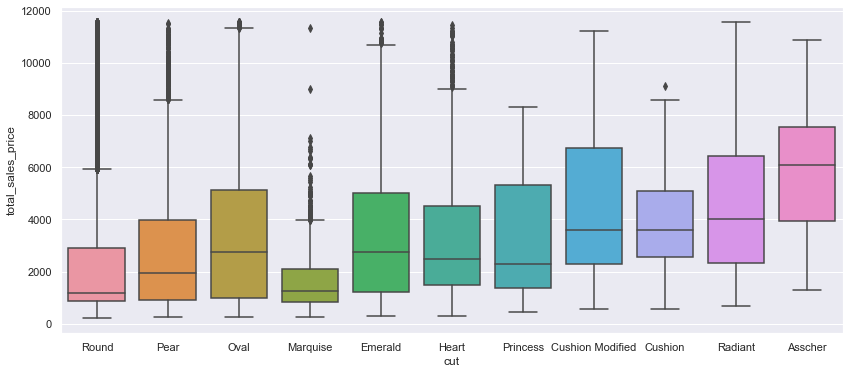

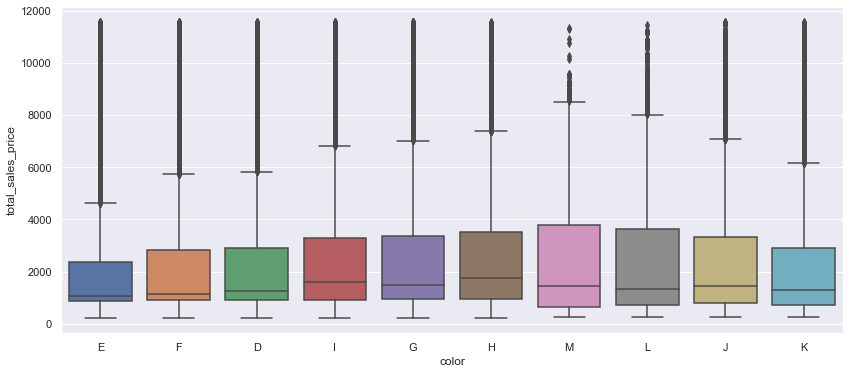

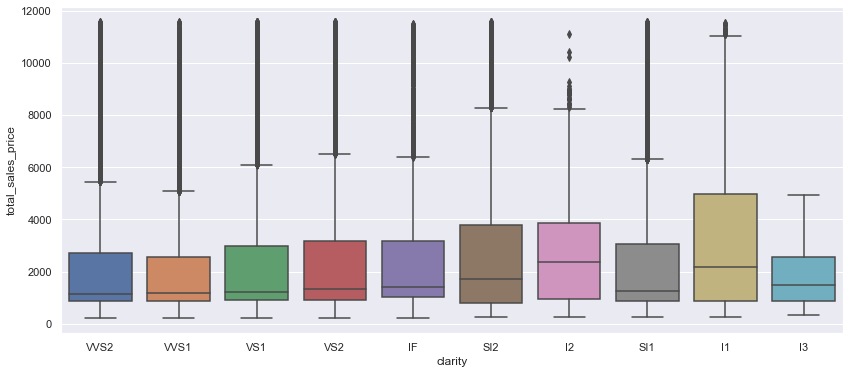

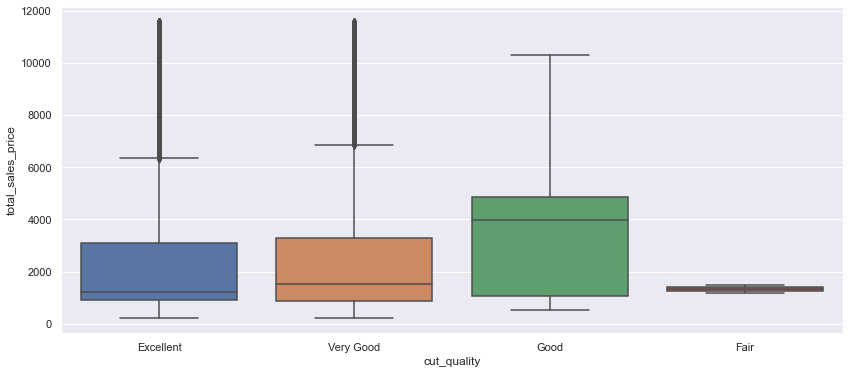

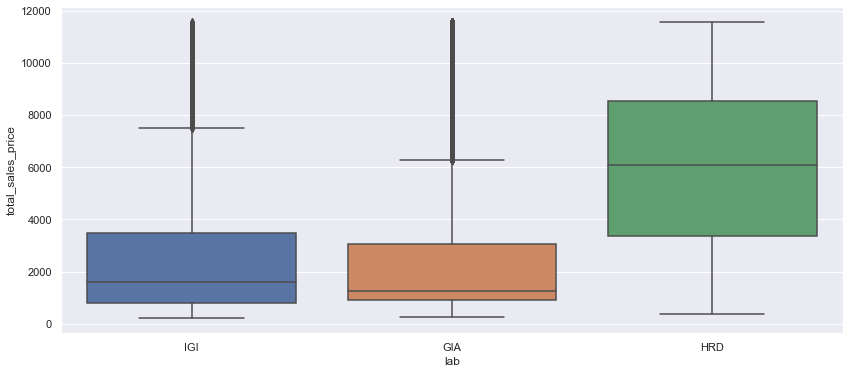

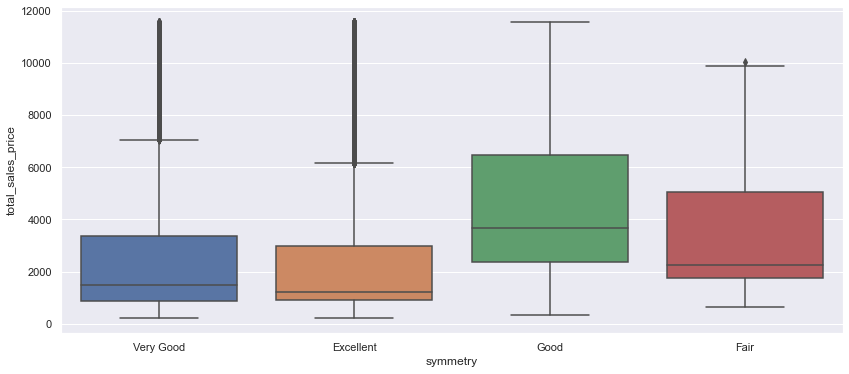

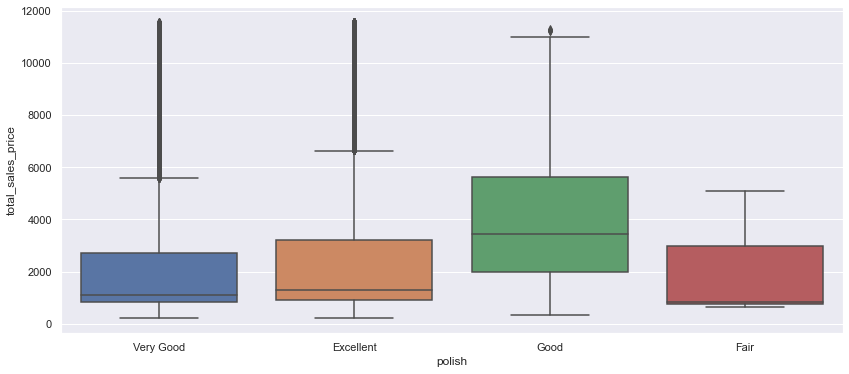

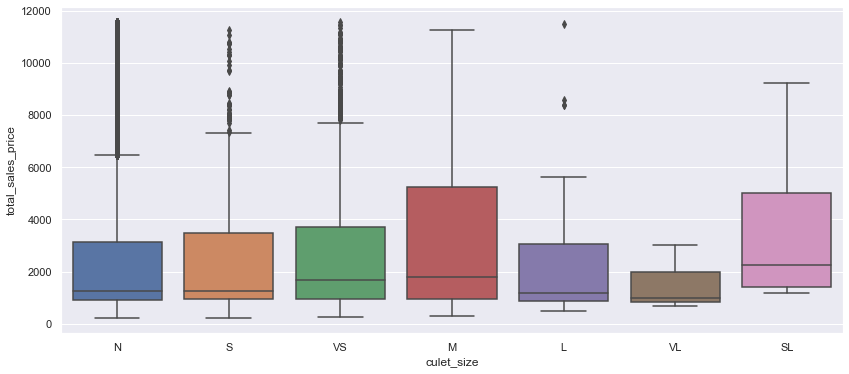

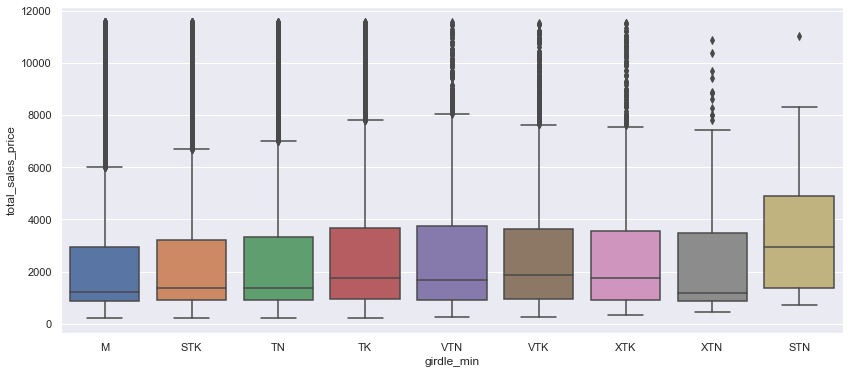

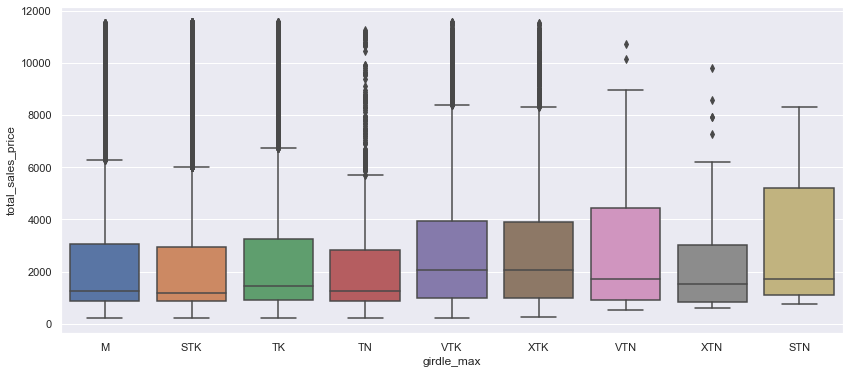

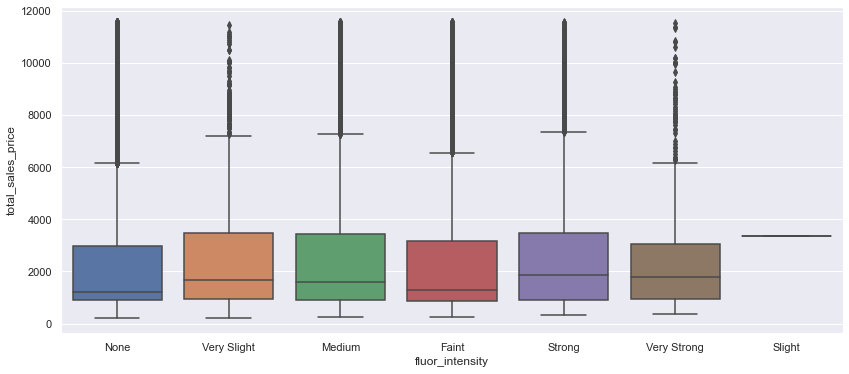

In [32]:
for var in EDA_cat:
    plt.figure(figsize=(14,6))
    sb.boxplot(x=var, y="total_sales_price", data=EDA_data)
    plt.show()

> Analysis:
> - Diamonds that are at the high end of price have round cuts but Asscher-cut diamonds are generally sold at a higher price than other forms of cut. 
> - Generally evenly distributed across all colours and hence may not be a good variable for prediction. This may be due to a human's inability to discern similar colors or due to the preference of individuals
> - Despite having 'Excellent' and 'Very Good' cut_quality, they are being sold at a relatively lower price than 'Good'. 'Fair' is also being sold at comparable prices and hence cut_quality may not be a good variable used to predict prices.
> - The few exceptionally costly diamonds have either GIA or IGI certificates but the majority of those with HRD certificates are sold at a higher price than the majority of those with GIA/IGI certificates. It is safe to say that a diamond with a HRD certificate should cost the average. 
> - The exceptionally costly diamonds have N culet size but there are also some with N culet size that are sold for a relatively low price. culet size may not be a good variable.


# Machine Learning

To achieve our objective to predict diamond price, we need to find a machine learning model with the best accuracy.

We tried many machine learning models, some of which were taught in this course, such as linear regression and classification tree. However, we deemed the results unsatisfactory, so we explored many other models.

In the end, we settled on three different models, linear regression, random forest, and extreme gradient boost, or XGBoost. 


Considering that we have many categorical variables, we need to encode them in some way.

We deem One Hot Encoding to be the best, as it creates encoding without hierarchy that might skew the result of Linear Regression.

> In order to have a complete model, we should use data that includes the numerical outliers, in contrast to the data we used for EDA

In [33]:
model_data = clean_data.copy()
model_data = model_data.reset_index()
model_data = model_data.drop(['level_0', 'index'], axis=1)

In [34]:
model_data

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,culet_size,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,fluor_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,N,62.7,59.0,2.85,2.87,1.79,M,M,None,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,N,61.9,59.0,2.84,2.89,1.78,STK,STK,None,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,N,61.1,59.0,2.88,2.90,1.77,TN,M,None,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,N,62.0,59.0,2.86,2.88,1.78,M,STK,None,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,N,64.9,58.5,2.79,2.83,1.82,STK,STK,None,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,N,61.3,58.0,14.06,14.18,8.66,M,STK,None,1210692
219699,Radiant,I,VS2,5.17,Very Good,GIA,Very Good,Very Good,N,64.8,65.0,11.55,8.81,5.71,TK,XTK,None,1292500
219700,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,N,60.2,59.0,17.06,17.10,10.20,TN,M,None,1315496
219701,Princess,F,SI2,0.90,Excellent,GIA,Good,Good,N,70.8,72.0,5.22,4.90,3.47,XTN,VTK,Faint,1350000


# 1. Encoding Categorical Variables

In [35]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder()

# Fit and transform the data
one_hot_encoded = encoder.fit_transform(model_data[cat_var])

column_names = encoder.get_feature_names_out(cat_var)

# concatenate the DataFrame with the one hot encoded values
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=column_names)
data_encoded = pd.concat([model_data, one_hot_encoded_df], axis=1)
data_encoded.drop(columns=cat_var, inplace=True)

model_data=data_encoded
model_data

,carat_weight,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price,cut_Asscher,cut_Cushion,cut_Cushion Modified,cut_Emerald,cut_Heart,cut_Marquise,cut_Oval,cut_Pear,cut_Princess,cut_Radiant,cut_Round,color_D,color_E,color_F,color_G,color_H,color_I,color_J,color_K,color_L,color_M,color_nan,clarity_I1,clarity_I2,clarity_I3,clarity_IF,clarity_SI1,clarity_SI2,clarity_SI3,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,cut_quality_Excellent,cut_quality_Fair,cut_quality_Good,cut_quality_Ideal,cut_quality_Very Good,cut_quality_nan,lab_GIA,lab_HRD,lab_IGI,symmetry_Excellent,symmetry_Fair,symmetry_Good,symmetry_Poor,symmetry_Very Good,polish_Excellent,polish_Fair,polish_Good,polish_Poor,polish_Very Good,culet_size_EL,culet_size_L,culet_size_M,culet_size_N,culet_size_S,culet_size_SL,culet_size_VL,culet_size_VS,culet_size_nan,girdle_min_M,girdle_min_STK,girdle_min_STN,girdle_min_TK,girdle_min_TN,girdle_min_VTK,girdle_min_VTN,girdle_min_XTK,girdle_min_XTN,girdle_min_nan,girdle_max_M,girdle_max_STK,girdle_max_STN,girdle_max_TK,girdle_max_TN,girdle_max_VTK,girdle_max_VTN,girdle_max_XTK,girdle_max_XTN,girdle_max_nan,fluor_intensity_Faint,fluor_intensity_Medium,fluor_intensity_None,fluor_intensity_Slight,fluor_intensity_Strong,fluor_intensity_Very Slight,fluor_intensity_Very Strong,fluor_intensity_nan
0,0.09,62.7,59.0,2.85,2.87,1.79,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.09,61.9,59.0,2.84,2.89,1.78,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.09,61.1,59.0,2.88,2.90,1.77,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.09,62.0,59.0,2.86,2.88,1.78,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.09,64.9,58.5,2.79,2.83,1.82,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,10.65,61.3,58.0,14.06,14.18,8.66,1210692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,

# 2. Assessing Performance
> In order to compare performance of each model, we are using $R^2$ value of the result. 

> The value of $R^2$ informs us the variability in predicted values as opposed to actual variability in the actual variable. Due to the specific range of $R^2$, that is, it always lie between 0 and 1, it gives us a scale of performance to better evaluate the model, in addition to the fact that the higher the value, the more accurate the model is.

> Compare that to MSE which does not have any standard or relative scale for our model to be said satisfactory and has only the fact that the smaller the value, the better it is. 

In [36]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 3. Splitting Train and Test Dataset
> $R^2$ value imported earlier is used to get a score to compare each models with.
>
> There is a concern of overfitting in any machine learning model.
>
> To mitigate this, we split the dataset into train and test dataset using `train_test_split` to do so in a random manner.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(model_data.drop('total_sales_price', axis=1), model_data['total_sales_price'], test_size=0.2, random_state=0)

> `X_train` and `y_train` is used to is used to create the model.
> 
> The train prediction result, `y_train_pred`, is the prediction of the model using `X_train`.

# 4. Comparing results
> The model from training data is then used to predict `y_train` using `X_train`, and the performance is compared using its $R^2$ value.
> 
> In order to ensure that there's no overfitting, we use the same model to predict test data, `y_test`, using `X_test`.
> 
> If no significant overfitting occurs, the $R^2$ value should be similar.

# 5. Machine Learning Models

## A. Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Evaluate the model on the train and testing set
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6255637206123482
Mean Squared Error (MSE) 	: 246372174.85900697

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6302943080410714
Mean Squared Error (MSE) 	: 272660125.34434843


> The result is far from satisfactory, so we then looked into the next model, **Random Forest.**

## B. Random Forest

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=16, random_state=0)

# Train the model
rf.fit(X_train, y_train)

# Evaluate the model on the train and testing set
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7806370939491603
Mean Squared Error (MSE) 	: 144336751.59768644

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.7730914026661561
Mean Squared Error (MSE) 	: 167346426.99963984


> The result is already much better than linear regression. To see if we can improve this, we tried using **eXtreme Gradient Boost (XGBoost)** model.

## C. XGBoost

In [40]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 3, 'learning_rate': 0.1, 'objective': 'reg:squarederror'}
num_round = 250

xgb_model = xgb.train(param, dtrain, num_round)

y_train_pred = xgb_model.predict(dtrain)
y_test_pred = xgb_model.predict(dtest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8570539641415265
Mean Squared Error (MSE) 	: 94055858.58165418

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8108292093816174
Mean Squared Error (MSE) 	: 139514572.27558112


> The result is marginally better than random forest, and this is the best model we found.

# 6. Hyperparameter Tuning
> To ensure that the result is as optimal as possible, we did **hyperparameter tuning** to the XGBoost model.
> 
> Hyperparametric tuning is a process in optimizing hyperparameters, a set of variables that is used to control the learning process. By optimizing hyperparameters, the learning process can be done in a way that ensures maximum performance. 
>
> Hyperparameters differ from parameters in a sense that parameters occur as a result of machine learning, while hyperparameters define the learning process itself. Think of how many layers in a neural network or how many depth should a classification tree have. This is not something generated as a result of machine learning and the control lies entirely on the data scientist. We want to modify this values so that it will give us the best model.

> One of the methods to do hyperparameter tuning is Grid Search. It specifies a grid of hyperparameters and evaluates them. This process runs through the entire possible subset of hyperparameters, which is a brute force approach. It evaluates all options and finally return the best values for the hyperparameters.

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {'max_depth': [3, 6],
              'learning_rate': [0.1, 0.25],
              'n_estimators': [50, 150]}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

# Use the best estimator to make predictions on the test data
best_estimator = grid_search.best_estimator_

y_train_pred = best_estimator.predict(X_train)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}
Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9482886657689888
Mean Squared Error (MSE) 	: 34025105.42031461


> The result is much better.
> 
> Therefore, we have found the best model and its parameters.
> - 'learning_rate': 0.25
> - 'max_depth': 6
> - 'n_estimators': 150
> 
> To ensure that there's no overfitting, we use the trained model on `X_test` to predict `y_test`.

In [42]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 6, 'learning_rate': 0.1, 'objective': 'reg:squarederror'}
num_round = 150

xgb_model = xgb.train(param, dtrain, num_round)

y_train_pred = xgb_model.predict(dtrain)
y_test_pred = xgb_model.predict(dtest)

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9482886657689888
Mean Squared Error (MSE) 	: 34025105.42031461

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8238461625034964
Mean Squared Error (MSE) 	: 129914492.67981634


> The difference in $R^2$ value is within an acceptable range, especially when it has a high overall $R^2$ value for both training and test dataset. Hence, we can conclude that there is no overfitting.

# Data Driven Insights

After a thorough exploration, here are our suggestions:

Buyers have to be aware that weight influences a diamond’s price and not just its physical appearance. This is due to high positive correlation between carat weight and price.

Lab manufacturing companies will have to choose to cut their diamonds Asscher to obtain a generally high price, or cut them in the round way for a potentially exceptional high price in the marketplace. This can be seen from the boxplot where the general trend increases with Asscher cut at the top, but very expensive diamonds (outliers) often have round cut. For buyers, as this is related to physical appearance, their preference should be taken into account.

Manufacturing companies as well as investors may want to consider obtaining the correct lab certification for their diamonds. Lab certification of the diamonds is a proof of high quality and thus often leads to exceptionally costly diamonds. They have GIA/IGI certificates. However, the majority of those with HRD certificates have higher prices than those with GIA/IGI certificates, so HRD certified diamonds generally have an average price. Again, this can be seen from the boxplot.
